# Data embedding and dimensionality reduction with Kohonen Self-Organizing Maps (SOMs)

## Imports

In [1]:
import os
import numpy as np
np.set_printoptions(precision=4)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

EPSILON = 10e-9

## Data reading utils

In [2]:
def read_animals_data(path_2_animals, path_2_animalnames, path_2_animalattributes):
    """ Reads animals data.
    
    Parameters
    ----------
    path_2_animals : str
        Path to animals.dat that contains the attributes of each animal.
    path_2_animalnames : str
        Path to animalnames.txt that contains the animals' names.
    path_2_animalattributes : str
        Path to animalattributes.txt that contains the attribute names.
    
    Returns
    -------
    df_animals : pandas.DataFrame
        DataFrame of animals data.
    """
    with open(path_2_animalnames) as f:
        animalnames = np.array([line.strip().strip("''") for line in f.readlines()])

    with open(path_2_animalattributes) as f:
        animalattributes = np.array([line.strip() for line in f.readlines()])

    patterns_animals = np.genfromtxt(path_2_animals, delimiter =',').reshape((animalnames.shape[0],-1))
    
    data_dict = \
        {animalattribute: patterns_animals[:, idx] for idx, animalattribute in enumerate(animalattributes)}
    
    df_no_names = pd.DataFrame(data=data_dict, columns=animalattributes, dtype=np.float)
    df_names = pd.DataFrame(data={"animalnames": animalnames})
    
    frames = [df_no_names, df_names]
    df_animals = pd.concat(frames, axis=1)
    
    return df_animals

In [3]:
def read_cities_data(path_2_cities_data):
    """ Reads cities data.
    
    Parameters
    ----------
    path_2_cities_data : str
        Path to cities.dat that contains the (x,y) coordinate location of each city.
    
    Returns
    -------
    df_cities : pandas.DataFrame
        DataFrame of cities data.
    """
    df_cities = pd.read_csv(path_2_cities_data, skiprows=3, sep=",", names=["x", "y"], dtype=str)
    df_cities["x"] = df_cities["x"].str.strip("")
    df_cities["y"] = df_cities["y"].str.strip("")
    df_cities["y"] = df_cities["y"].str.strip(";")
    df_cities["x"] = pd.to_numeric(df_cities["x"])
    df_cities["y"] = pd.to_numeric(df_cities["y"])
    
    return df_cities

In [4]:
def read_votes_data(path_2_votes, path_2_mpparty, path_2_mpsex, path_2_mpdistrict, path_2_mpnames):
    """ Reads votes data.
    
    Parameters
    ----------
    path_2_votes : str
        Path to votes.dat that contains 31 votes per member of parliament.
    path_2_mpparty : str
        Path to mpparty.dat that contains the party of each member of parliament.
    path_2_mpsex : str
        Path to mpsex.dat that contains the sex of each member of parliament.
    path_2_mpdistrict : str
        Path to mpdistrict.dat that contains the district of each member of parliament.
    path_2_mpnames : str
        Path to mpnames.dat that contains the names of each member of parliament.
        
    Returns
    -------
    df_votes : pandas.DataFrame
        DataFrame of votes data.
    """
    df_mpparty = pd.read_csv(path_2_mpparty, skiprows=2, names=["mpparty"])
    df_mpsex = pd.read_csv(path_2_mpsex, skiprows=2, names=["mpsex"])
    df_mpdistrict = pd.read_csv(path_2_mpdistrict, names=["mpdistrict"])
    df_mpnames = pd.read_csv(path_2_mpnames, names=["mpnames"], encoding='latin1')
    
    votes_np = np.genfromtxt(path_2_votes, delimiter =',').reshape((df_mpnames.shape[0],-1))
    patterns_dict = {str(k):votes_np[:,k] for k in range(votes_np.shape[1])}
    df_patterns = pd.DataFrame.from_dict(data=patterns_dict, dtype=np.float)
    
    frames = [df_patterns, df_mpparty, df_mpsex, df_mpdistrict, df_mpnames]
    df_votes = pd.concat(frames, axis=1)
    
    mpparty_map = {0: "no party", 1: 'm', 2: 'fp', 3: 's', 4: 'v', 5: 'mp', 6: 'kd', 7: 'c'}
    mpsex_map = {0: "male", 1: 'female'}
    df_votes.replace({"mpparty": mpparty_map, 'mpsex': mpsex_map}, inplace=True)
    
    return df_votes

## SOM for embedding data into 2D space

In [5]:
class SOM_2D():
    """ Kohonen Self-Organizing Map (SOM) for embedding data into 2D.
    
    Attributes
    ----------
    w_map : numpy.ndarray
        The learnable parameters, weights of the SOM.
    trained : bool
        If SOM has been fit to some data.

    Methods
    -------
    get_input_space_distances(pattern)
        Computes the distance of each weight vector to the data vector, pattern.
    get_winner(input_space_distances)
        Computes the winner node in the SOM lattice, that is, the weight vector that
        is closest to the data vector, pattern, based on the distance matrix input_space_distances.
    get_output_space_distances(winner_idx, **rule_dict)
        Computes the Manhattan distance of each lattice node from the winner, based on the 2D
        indices of the nodes in the lattice (gives rise to the 2D topology for embedding).
    get_neighbourhood_mask(output_space_distances, epoch, **rule_dict)
        Applies a neighbourhood rule to the Manhattan distances in the output space. 
        Decays with epoch.
    update_weights(pattern, neighbourhood_mask, lr)
        Updates the learnable weights using the neighbourhood rule based on the data vector pattern. 
    fit(patterns, lr, epochs, **rule_dict)
        Fit SOM to teh dataset patterns.
    embed(patterns)
        Embed dataset patterns into the 2D lattice based on the winner nodes per pattern.
    """
    def __init__(self, n_rows, n_cols, n_features, seed):
        # Set the random seed before initializing the weights.
        if seed is not None:
            np.random.seed(seed)
        else:
            np.random.seed()
        
        self.w_map = np.random.normal(0, 1, size=(n_rows, n_cols, n_features))        
        self.trained = False
        
    def get_input_space_distances(self, pattern):
        """ Computes the distance of each weight vector to the data vector, pattern.
    
        Parameters
        ----------
        pattern : numpy.ndarray
            Data vector of shape (self.w_map.shape[2], ).

        Returns
        -------
        input_space_distances : numpy.ndarray
            The distance of each weight vector from the data vector pattern in the 
            input space, of shape (self.w_map.shape[0], self.w_map.shape[1])
        """
        input_space_distances = np.zeros((self.w_map.shape[0], self.w_map.shape[1]))
        
        for idx_row, w_row in enumerate(self.w_map):
            for idx_col, w in enumerate(w_row):
                input_space_distances[idx_row, idx_col] = np.linalg.norm(pattern - w)
        
        return input_space_distances
    
    def get_winner(self, input_space_distances):
        """ Computes the winner node in the SOM lattice, that is, the weight vector that
        is closest to the data vector, pattern, based on the distance matrix input_space_distances.
    
        Parameters
        ----------
        input_space_distances : numpy.ndarray
            The distance of each weight vector from the data vector pattern in the 
            input space, of shape (self.w_map.shape[0], self.w_map.shape[1])

        Returns
        -------
        winner_idx : numpy.ndarray
            The index of the winner node, of shape (2,)
        winner_error : float
            The Euclidean distance of the winner node from the data vector, viewed as the 
            embedding error for the data vector.
        """
        winner_idx_flattened = np.argmin(input_space_distances)
        winner_idx = np.array([winner_idx_flattened // self.w_map.shape[1], 
                               winner_idx_flattened % self.w_map.shape[1]])
        winner_error = np.min(input_space_distances)
        return winner_idx, winner_error
    
    def get_output_space_distances(self, winner_idx, **rule_dict):
        """ Computes the Manhattan distance of each lattice node from the winner, based on the 2D
        indices of the nodes in the lattice (gives rise to the 2D topology for embedding).
    
        Parameters
        ----------
        winner_idx : numpy.ndarray
            The index of the winner node, of shape (2,)
        rule_dict : dict
            Parameters of the neighbour rule.

        Returns
        -------
        output_space_distances : numpy.ndarray
            The Manhattan distance of each weight vector from the winner vector, or node, in
            terms of indices, of shape (self.w_map.shape[0], self.w_map.shape[1])
        """
        indices = np.indices(dimensions=(self.w_map.shape[0], self.w_map.shape[1]))
        distances_x_y = np.abs((indices.T - winner_idx).T)
        
        # If wrap, then the SOM lattice wraps around, so nodes on the opposite side 
        # of the lattice could be closer to the winner node (cyclic lattice).
        if rule_dict["wrap"]:
            distances_x_y_inv = distances_x_y.copy()
            distances_x_y_inv[0] = self.w_map.shape[0] - distances_x_y_inv[0]
            distances_x_y_inv[1] = self.w_map.shape[1] - distances_x_y_inv[1]
            distances_x_y_min = np.minimum(distances_x_y, distances_x_y_inv)
        else:
            distances_x_y_min = distances_x_y.copy()
        
        output_space_distances = np.sum(distances_x_y_min, axis=0)
        
        return output_space_distances
    
    def get_neighbourhood_mask(self, output_space_distances, epoch, **rule_dict):
        """ Applies a neighbourhood rule to the Manhattan distances in the output space. 
        Decays with epoch.
    
        Parameters
        ----------
        output_space_distances : numpy.ndarray
            The Manhattan distance of each weight vector from the winner vector, or node, in
            terms of indices, of shape (self.w_map.shape[0], self.w_map.shape[1])
        epoch : int
            The current epoch number.
        rule_dict : dict
            Parameters of the neighbour rule.

        Returns
        -------
        neighbourhood_mask : numpy.ndarray
            The neighbourhood mask that contains a real number between 0-1 defining 
            the strength of the weight update of each node, 
            of shape (self.w_map.shape[0], self.w_map.shape[1])
        """
        # The nodes at maximum of n distance (Manhattan) will be updated
        if rule_dict["rule"] == "n_neighbours":
            ns = rule_dict["ns"]
            n = ns[epoch]
            neighbourhood_mask = np.zeros(output_space_distances.shape)
            neighbourhood_mask[output_space_distances <= n] = 1.0
        # Nodes close to the winner will be updated more, further ones less, 
        # based on a Gaussian function
        elif rule_dict["rule"] == "gaussian_neighbours":
            sigmas = rule_dict["sigmas"]
            sigma = sigmas[epoch]
            neighbourhood_mask = \
                np.exp(-0.5*(output_space_distances / (sigma + EPSILON))**2)
            
        else:
            raise NotImplementedError("Invalid neighbourhood rule.")
        
        return neighbourhood_mask
    
    def update_weights(self, pattern, neighbourhood_mask, lr):
        """ Updates the learnable weights using the neighbourhood rule based on the data vector pattern. 
    
        Parameters
        ----------
        pattern : numpy.ndarray
            Data vector of shape (self.w_map.shape[2], ).
        neighbourhood_mask : numpy.ndarray
            The neighbourhood mask that contains a real number between 0-1 defining 
            the strength of the weight update of each node, 
            of shape (self.w_map.shape[0], self.w_map.shape[1])
        lr : float
            The learning rate of the SOM, i.e.: the general strenght of the weight update of
            each weight vector, or node.

        Returns
        -------
        None
        """
        d_w_map = np.zeros(self.w_map.shape)
        
        for idx_row, w_row in enumerate(self.w_map):
            for idx_col, w in enumerate(w_row):
                d_w_map[idx_row, idx_col] = lr * neighbourhood_mask[idx_row, idx_col] * (pattern - w)

        self.w_map += d_w_map
    
    def fit(self, patterns, lr, epochs, **rule_dict):
        """ Fit SOM to teh dataset patterns.
    
        Parameters
        ----------
        patterns : numpy.ndarray
            Dataset of shape (n_data, self.w_map.shape[2]) that contains the data vectors
            of shape (self.w_map.shape[2], ).
        lr : float
            The learning rate of the SOM, i.e.: the general strenght of the weight update of
            each weight vector, or node.
        epochs : int
            The number of epochs of the SOM training.
        rule_dict : dict
            Parameters of the neighbour rule.

        Returns
        -------
        None
        """
        errors = []
        
        for epoch in range(epochs):
            errors_per_epoch = []
            
            for pattern in patterns:
                input_space_distances = self.get_input_space_distances(pattern)
                winner_idx, winner_error = self.get_winner(input_space_distances)
                errors_per_epoch.append(winner_error)
                output_space_distances = self.get_output_space_distances(winner_idx, **rule_dict)
                neighbourhood_mask = self.get_neighbourhood_mask(output_space_distances, epoch, **rule_dict)
                self.update_weights(pattern, neighbourhood_mask, lr)
            
            mean_error_per_epoch = np.array(errors_per_epoch).mean()
            errors.append(mean_error_per_epoch)
            print(f"epoch {epoch+1}: err: {mean_error_per_epoch:.4e}")
        
        plt.figure(figsize=(12,6))
        plt.plot(errors)
        plt.xlabel("Epochs", fontsize=12)
        plt.ylabel("Mean Error Per Epoch", fontsize=12)
        plt.title("SOM Embedding Error per Epoch")
        plt.xticks(range(epochs))
        plt.grid()
        plt.show()
        self.trained = True
        
    def embed(self, patterns):
        """ Embed dataset patterns into the 2D lattice based on the winner nodes per pattern.
    
        Parameters
        ----------
        patterns : numpy.ndarray
            Dataset of shape (n_data, self.w_map.shape[2]) that contains the data vectors
            of shape (self.w_map.shape[2], ).

        Returns
        -------
        winners_idx : numpy.ndarray
            The winner nodes' indices per data vector pattern, of shape (n_data, 2)
        """
        winners_idx = []
        
        for pattern in patterns:
            input_space_distances = self.get_input_space_distances(pattern)
            winner_idx, winner_error = self.get_winner(input_space_distances)
            winners_idx.append(winner_idx)
        
        winners_idx = np.array(winners_idx)
        
        return winners_idx
    
    def __repr__(self):
        return f"w_map shape: {self.w_map.shape}, trained: {self.trained}"

## Topological Ordering of Animal Species

A dataset of 32 animal species is embedded with SOM where each animal is characterized by 84 binary attributes. The data is in the animals.dat file. This file defines a 32x84 matrix were each row contrains the attributes of one animal. The data are organised in row-by-row manner. There is also a file animalnames.dat with the names of the animals in teh same order. This vector is used to print out the final ordering of animals in a more readable format. The 84 attributes of each anmial serve as input and 100 nodes arranged in a one-dimensional topology, i.e. in a linear sequence, constitute the output. That is, the 84-dimensional data is embedded into 1 dimensions with SOM.

Read animals data.

In [6]:
path_2_animals = os.path.join(os.path.abspath(''), "data/animals.dat")
path_2_animalnames = os.path.join(os.path.abspath(''), "data/animalnames.txt")
path_2_animalattributes = os.path.join(os.path.abspath(''), "data/animalattributes.txt")

df_animals = read_animals_data(path_2_animals, path_2_animalnames, path_2_animalattributes)
df_animals

,antlered,articulations,barks,big,bigears,biting,black,blood,brown,climbing,...,warmblooded,waterliving,verybig,verylongears,verysmall,white,wingless,wings,yellow,animalnames
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,antelop
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ape
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,bat
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,bear
4,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,beetle
5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,butterfly
6,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,camel
7,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,cat
8,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,crocodile
9,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,dog


Fit SOM to animals data

epoch 1: err: 3.5459e+00
epoch 2: err: 2.5119e+00
epoch 3: err: 2.3253e+00
epoch 4: err: 2.2380e+00
epoch 5: err: 2.1669e+00
epoch 6: err: 2.1061e+00
epoch 7: err: 2.0315e+00
epoch 8: err: 1.9568e+00
epoch 9: err: 1.8762e+00
epoch 10: err: 1.7926e+00
epoch 11: err: 1.7002e+00
epoch 12: err: 1.5947e+00
epoch 13: err: 1.4710e+00
epoch 14: err: 1.3271e+00
epoch 15: err: 1.1631e+00
epoch 16: err: 9.9002e-01
epoch 17: err: 8.1740e-01
epoch 18: err: 6.6202e-01
epoch 19: err: 5.3199e-01
epoch 20: err: 4.2600e-01


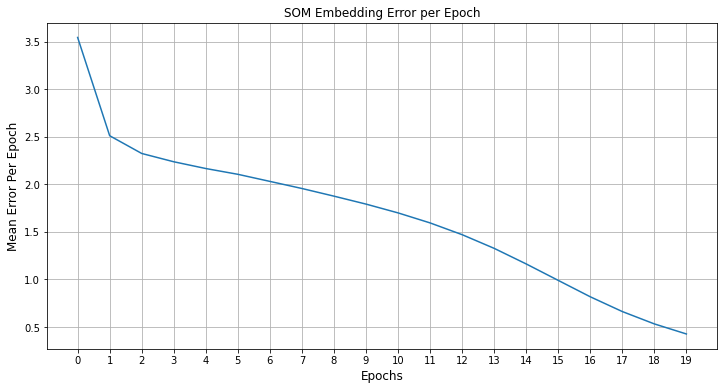

w_map shape: (100, 1, 84), trained: True


In [7]:
seed = 12

patterns_animals = df_animals.iloc[:, :84].to_numpy()

n_rows, n_cols, n_features = 100, 1, patterns_animals.shape[1]

lr = 0.2
epochs = 20

som_2d = SOM_2D(n_rows, n_cols, n_features, seed)

"""n_0 = 10
ns = np.linspace(0, n_0, epochs, dtype=int)[::-1]
rule_dict = {"rule": "n_neighbours", "ns": ns, "wrap": True}"""

sigma_0 = 10
decay_rate = 100
sigmas = [sigma_0 * np.exp(-epoch**2 / decay_rate) for epoch in range(epochs)]
rule_dict = {"rule": "gaussian_neighbours", "sigmas": sigmas, "wrap": False}

som_2d.fit(patterns_animals, lr, epochs, **rule_dict)
print(som_2d)

Order the winner nodes per animal, and list the animals based on their winner node (i.e.: embedding)

In [8]:
winners_idx_animals = som_2d.embed(patterns_animals)

animalnames_sorted = [x for _,x in sorted(zip(winners_idx_animals[:,0], df_animals["animalnames"]))]
winners_animals_sorted = sorted(winners_idx_animals[:,0])

for w, a in zip(animalnames_sorted, winners_animals_sorted):
    print(f"{w}: {a}")

spider: 0
housefly: 4
beetle: 8
grasshopper: 10
butterfly: 12
dragonfly: 16
moskito: 19
pelican: 24
duck: 27
ostrich: 30
penguin: 33
frog: 38
seaturtle: 41
crocodile: 43
walrus: 47
bear: 51
hyena: 53
dog: 54
skunk: 57
rat: 59
bat: 61
cat: 64
lion: 66
ape: 69
rabbit: 72
elephant: 75
kangaroo: 78
antelop: 82
horse: 86
giraffe: 90
camel: 92
pig: 95


## Cyclic Tour

The location of the ten cities is defined in the file the cities.dat which contains the 10 × 2 matrix of coordinates. Each row contains the coordinates of one city (value between zero and one). The SOM algorithm is used to find the shortest path between these cities (i.e.: travelling salesman problem) via embedding the 2 diemnsional data into 1 dimension. Importantly, the 1 dimensional SOM lattice topology wraps around.

In [9]:
path_2_cities_data = os.path.join(os.path.abspath(''), "data/cities.dat")
df_cities = read_cities_data(path_2_cities_data)

df_cities

,x,y
0,0.4000,0.4439
1,0.2439,0.1463
2,0.1707,0.2293
3,0.2293,0.7610
4,0.5171,0.9414
5,0.8732,0.6536
6,0.6878,0.5219
7,0.8488,0.3609
8,0.6683,0.2536
9,0.6195,0.2634


epoch 1: err: 2.2317e-01
epoch 2: err: 2.4285e-01
epoch 3: err: 2.5267e-01
epoch 4: err: 2.4454e-01
epoch 5: err: 2.4454e-01
epoch 6: err: 2.4455e-01
epoch 7: err: 2.4455e-01
epoch 8: err: 2.4455e-01
epoch 9: err: 2.4455e-01
epoch 10: err: 2.4455e-01
epoch 11: err: 2.4455e-01
epoch 12: err: 2.4455e-01
epoch 13: err: 2.4455e-01
epoch 14: err: 2.2070e-01
epoch 15: err: 2.0473e-01
epoch 16: err: 2.0385e-01
epoch 17: err: 2.0385e-01
epoch 18: err: 2.0385e-01
epoch 19: err: 2.0385e-01
epoch 20: err: 2.0385e-01
epoch 21: err: 2.0385e-01
epoch 22: err: 2.0385e-01
epoch 23: err: 2.0385e-01
epoch 24: err: 2.0385e-01
epoch 25: err: 2.0385e-01
epoch 26: err: 1.9555e-01
epoch 27: err: 1.7280e-01
epoch 28: err: 1.6337e-01
epoch 29: err: 1.6887e-01
epoch 30: err: 1.6961e-01
epoch 31: err: 1.6968e-01
epoch 32: err: 1.6968e-01
epoch 33: err: 1.6968e-01
epoch 34: err: 1.6969e-01
epoch 35: err: 1.6969e-01
epoch 36: err: 1.6969e-01
epoch 37: err: 1.6969e-01
epoch 38: err: 1.1264e-01
epoch 39: err: 5.4219

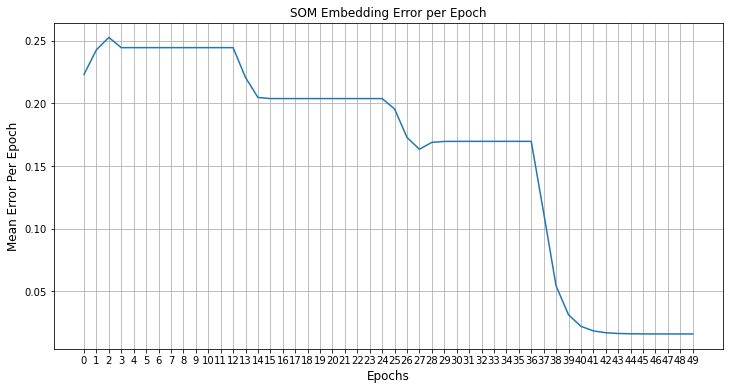

In [10]:
seed = 21
    
patterns_cities = df_cities.to_numpy()

n_rows, n_cols, n_features = 10, 1, patterns_cities.shape[1]

lr = 0.6
epochs = 50

som_2d = SOM_2D(n_rows, n_cols, n_features, seed)

n_0 = 4
ns = np.linspace(0, n_0, epochs, dtype=int)[::-1]
rule_dict = {"rule": "n_neighbours", "ns": ns, "wrap": True}

"""sigma_0 = 8
decay_rate = 20
sigmas = [sigma_0 * np.exp(-epoch**2 / decay_rate) for epoch in range(epochs)]
rule_dict = {"rule": "gaussian_neighbours", "sigmas": sigmas, "wrap": False}"""

som_2d.fit(patterns_cities, lr, epochs, **rule_dict)

In [11]:
winners_idx_cities = som_2d.embed(patterns_cities)
cities_sorted = [x for _,x in sorted(zip(winners_idx_cities[:, 0],list(df_cities.index.values)))]
winners_cities_sorted = sorted(winners_idx_cities[:, 0])

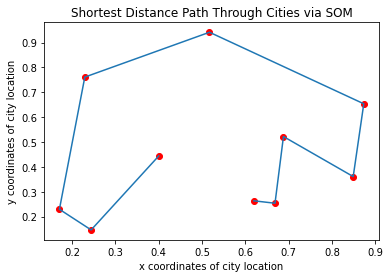

In [12]:
plt.scatter(df_cities["x"], df_cities["y"], color="r")
df_cities["order"] = winners_cities_sorted
df_cities_sorted = df_cities.sort_values(by='order', ascending=0)
plt.plot(df_cities_sorted["x"], df_cities_sorted["y"])
plt.xlabel("x coordinates of city location")
plt.ylabel("y coordinates of city location")
plt.title("Shortest Distance Path Through Cities via SOM")
plt.show()

## Data Clustering: Votes of Swedish MPs

The file votes.dat contains data about how all 349 members of the Swedish parliament voted in the 31 first votes between 2004-2005. There are also three additional files mpparty.dat, mpsex.dat and mpdistrict.dat with information about the party, gender and district of each member of parliament (MP). Finally, there is a file mpnames.txt with the names of the MPs. The SOM algorithm is used to position all MPs on a 10 × 10 grid according to their votes. That is, the 31 dimensional data is embedded into 2 dimensions with the SOM.

In [13]:
path_2_votes = os.path.join(os.path.abspath(''), "data/votes.dat")
path_2_mpparty = os.path.join(os.path.abspath(''), "data/mpparty.dat")
path_2_mpsex = os.path.join(os.path.abspath(''), "data/mpsex.dat")
path_2_mpdistrict = os.path.join(os.path.abspath(''), "data/mpdistrict.dat")
path_2_mpnames = os.path.join(os.path.abspath(''), "data/mpnames.txt")

df_votes = read_votes_data(path_2_votes, path_2_mpparty, path_2_mpsex, path_2_mpdistrict, path_2_mpnames)
df_votes

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,mpparty,mpsex,mpdistrict,mpnames
0,0.0,1.0,0.0,0.5,0.0,0.0,1.0,0.5,0.0,0.0,...,0.5,1.0,0.0,0.5,0.0,1.0,m,male,1,Skårman Carl-Erik
1,0.0,1.0,1.0,0.5,0.0,0.0,1.0,0.5,0.0,0.0,...,0.5,1.0,1.0,0.0,0.5,0.0,fp,male,1,Romanus Gabriel
2,0.0,1.0,0.0,0.5,0.0,0.0,1.0,0.5,0.0,0.0,...,0.5,1.0,0.0,0.5,0.0,1.0,m,male,1,Odenberg Mikael
3,0.0,1.0,0.0,0.5,0.0,0.0,1.0,0.5,0.0,0.0,...,0.5,1.0,0.0,0.5,0.0,1.0,m,male,1,Järrel Henrik S
4,1.0,1.0,1.0,1.0,1.0,1.0,0.5,1.0,1.0,1.0,...,0.5,1.0,1.0,1.0,1.0,0.5,s,female,1,Lindgren Sylvia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344,1.0,1.0,1.0,1.0,1.0,1.0,0.5,1.0,1.0,1.0,...,0.5,1.0,1.0,1.0,1.0,0.5,s,female,29,Åström Karin
345,1.0,1.0,1.0,1.0,1.0,1.0,0.5,1.0,1.0,1.0,...,0.5,1.0,1.0,1.0,1.0,0.5,s,female,29,Gidblom Birgitta
346,1.0,1.0,1.0,1.0,1.0,1.0,0.5,1.0,1.0,1.0,...,0.5,1.0,1.0,1.0,1.0,0.5,s,female,29,Öberg Maria
347,0.0,1.0,0.0,0.5,0.0,0.0,1.0,0.5,0.0,0.0,...,0.5,0.5,0.5,0.5,0.5,0.5,m,male,29,Hammarbergh Krister


epoch 1: err: 1.9096e+00
epoch 2: err: 1.8667e+00
epoch 3: err: 1.7821e+00
epoch 4: err: 1.6200e+00
epoch 5: err: 1.4290e+00
epoch 6: err: 1.0863e+00
epoch 7: err: 6.0724e-01
epoch 8: err: 3.6433e-01
epoch 9: err: 2.3257e-01
epoch 10: err: 1.6436e-01
epoch 11: err: 1.3718e-01
epoch 12: err: 1.2513e-01
epoch 13: err: 1.1895e-01
epoch 14: err: 1.1378e-01
epoch 15: err: 1.1069e-01
epoch 16: err: 1.0862e-01
epoch 17: err: 1.0721e-01
epoch 18: err: 1.0624e-01
epoch 19: err: 1.0556e-01
epoch 20: err: 1.0510e-01


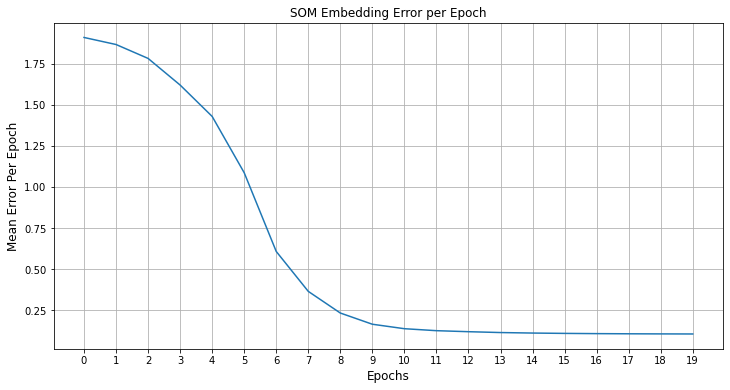

In [14]:
patterns_votes = df_votes.iloc[:, :31].to_numpy()

n_rows, n_cols, n_features = 10, 10, patterns_votes.shape[1]

lr = 0.3
epochs = 20

som_2d = SOM_2D(n_rows, n_cols, n_features, seed)

"""n_0 = 10
ns = np.linspace(0, n_0, epochs, dtype=int)[::-1]
rule_dict = {"rule": "n_neighbours", "ns": ns, "wrap": True}
"""
sigma_0 = 10
decay_rate = 20
sigmas = [sigma_0 * np.exp(-epoch**2 / decay_rate) for epoch in range(epochs)]
rule_dict = {"rule": "gaussian_neighbours", "sigmas": sigmas, "wrap":True}

som_2d.fit(patterns_votes, lr, epochs, **rule_dict)

In [15]:
winners_idx = som_2d.embed(patterns_votes)

dict_embedded = {"x": winners_idx[:, 0], "y": winners_idx[:, 1]}
df_votes_embedded = pd.DataFrame(data=dict_embedded)

frames = [df_votes, df_votes_embedded]
df_votes_plot = pd.concat(frames, axis=1)

df_votes_plot

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,mpparty,mpsex,mpdistrict,mpnames,x,y
0,0.0,1.0,0.0,0.5,0.0,0.0,1.0,0.5,0.0,0.0,...,0.0,0.5,0.0,1.0,m,male,1,Skårman Carl-Erik,4,9
1,0.0,1.0,1.0,0.5,0.0,0.0,1.0,0.5,0.0,0.0,...,1.0,0.0,0.5,0.0,fp,male,1,Romanus Gabriel,7,6
2,0.0,1.0,0.0,0.5,0.0,0.0,1.0,0.5,0.0,0.0,...,0.0,0.5,0.0,1.0,m,male,1,Odenberg Mikael,2,8
3,0.0,1.0,0.0,0.5,0.0,0.0,1.0,0.5,0.0,0.0,...,0.0,0.5,0.0,1.0,m,male,1,Järrel Henrik S,4,9
4,1.0,1.0,1.0,1.0,1.0,1.0,0.5,1.0,1.0,1.0,...,1.0,1.0,1.0,0.5,s,female,1,Lindgren Sylvia,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344,1.0,1.0,1.0,1.0,1.0,1.0,0.5,1.0,1.0,1.0,...,1.0,1.0,1.0,0.5,s,female,29,Åström Karin,3,3
345,1.0,1.0,1.0,1.0,1.0,1.0,0.5,1.0,1.0,1.0,...,1.0,1.0,1.0,0.5,s,female,29,Gidblom Birgitta,3,3
346,1.0,1.0,1.0,1.0,1.0,1.0,0.5,1.0,1.0,1.0,...,1.0,1.0,1.0,0.5,s,female,29,Öberg Maria,3,3
347,0.0,1.0,0.0,0.5,0.0,0.0,1.0,0.5,0.0,0.0,...,0.5,0.5,0.5,0.5,m,male,29,Hammarbergh Krister,5,9


Add noise to points (otherwise they would all lie exactly on the lattice nodes)

In [16]:
seed = 12
if seed is not None:
    np.random.seed(seed)
else:
    np.random.seed()

df_votes_plot["x"] = df_votes_plot["x"] + np.random.normal(0, 0.15, size=(df_votes_plot.shape[0])) 
df_votes_plot["y"] = df_votes_plot["y"] + np.random.normal(0, 0.15, size=(df_votes_plot.shape[0])) 

df_votes_plot

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,mpparty,mpsex,mpdistrict,mpnames,x,y
0,0.0,1.0,0.0,0.5,0.0,0.0,1.0,0.5,0.0,0.0,...,0.0,0.5,0.0,1.0,m,male,1,Skårman Carl-Erik,4.070948,9.205579
1,0.0,1.0,1.0,0.5,0.0,0.0,1.0,0.5,0.0,0.0,...,1.0,0.0,0.5,0.0,fp,male,1,Romanus Gabriel,6.897786,5.890680
2,0.0,1.0,0.0,0.5,0.0,0.0,1.0,0.5,0.0,0.0,...,0.0,0.5,0.0,1.0,m,male,1,Odenberg Mikael,2.036366,7.819414
3,0.0,1.0,0.0,0.5,0.0,0.0,1.0,0.5,0.0,0.0,...,0.0,0.5,0.0,1.0,m,male,1,Järrel Henrik S,3.744890,9.184394
4,1.0,1.0,1.0,1.0,1.0,1.0,0.5,1.0,1.0,1.0,...,1.0,1.0,1.0,0.5,s,female,1,Lindgren Sylvia,3.112971,3.116933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344,1.0,1.0,1.0,1.0,1.0,1.0,0.5,1.0,1.0,1.0,...,1.0,1.0,1.0,0.5,s,female,29,Åström Karin,3.059806,2.949234
345,1.0,1.0,1.0,1.0,1.0,1.0,0.5,1.0,1.0,1.0,...,1.0,1.0,1.0,0.5,s,female,29,Gidblom Birgitta,3.329018,2.929128
346,1.0,1.0,1.0,1.0,1.0,1.0,0.5,1.0,1.0,1.0,...,1.0,1.0,1.0,0.5,s,female,29,Öberg Maria,2.976108,2.841187
347,0.0,1.0,0.0,0.5,0.0,0.0,1.0,0.5,0.0,0.0,...,0.5,0.5,0.5,0.5,m,male,29,Hammarbergh Krister,5.077206,9.072966


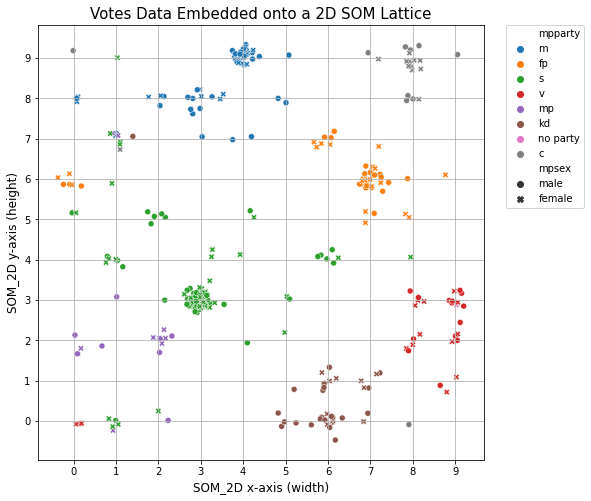

In [17]:
plt.figure(figsize=(8,8))

sc = sns.scatterplot(x="x", y="y", hue="mpparty", style='mpsex', data=df_votes_plot)
sc.set_xticks([i for i in range(som_2d.w_map.shape[1])])
sc.set_yticks([i for i in range(som_2d.w_map.shape[0])])

plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel("SOM_2D x-axis (width)", fontsize= 12)
plt.ylabel("SOM_2D y-axis (height)", fontsize= 12)
plt.title("Votes Data Embedded onto a 2D SOM Lattice", fontsize= 15)

plt.show()

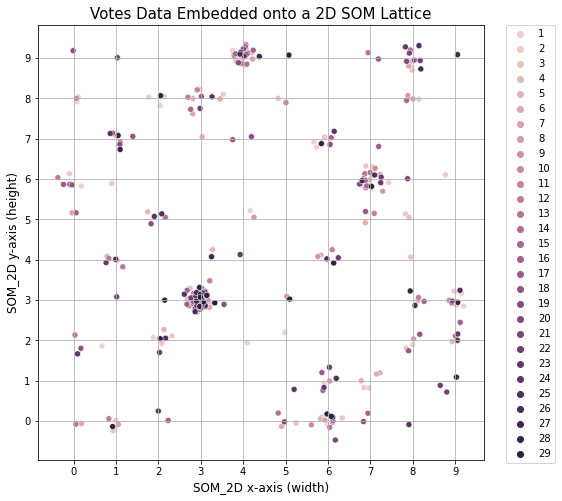

In [18]:
plt.figure(figsize=(8,8))

sc = sns.scatterplot(x="x", y="y", hue="mpdistrict", data=df_votes_plot, legend="full")
sc.set_xticks([i for i in range(som_2d.w_map.shape[1])])
sc.set_yticks([i for i in range(som_2d.w_map.shape[0])])

plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel("SOM_2D x-axis (width)", fontsize= 12)
plt.ylabel("SOM_2D y-axis (height)", fontsize= 12)
plt.title("Votes Data Embedded onto a 2D SOM Lattice", fontsize= 15)

plt.show()